In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from scipy.stats import skew
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
df = pd.read_csv('Data/proportional_disaggregation.csv')

In [15]:
def create_adstock_features(df, spend_column, decay_rates=[0.8, 0.9], max_lags=[2, 3, 4, 5], vif_threshold=10.0):
    temp_df = pd.DataFrame()
    spend_series = df[spend_column].values
    n = len(spend_series)

    for decay in decay_rates:
        for lag in max_lags:
            col_name = f"adstock_d{decay}_l{lag}"
            transformed = np.zeros(n)
            for t in range(n):
                cum_effect = 0
                for k in range(0, min(lag, t) + 1):
                    cum_effect += (decay ** k) * spend_series[t - k]
                transformed[t] = cum_effect
            temp_df[col_name] = transformed

    adstock_df = temp_df.loc[:, temp_df.std() > 1e-8]

    dropped = True
    while dropped and adstock_df.shape[1] > 1:
        dropped = False
        try:
            X_with_const = sm.add_constant(adstock_df)
            vif_vals = []
            for i in range(1, X_with_const.shape[1]):
                vif_val = variance_inflation_factor(X_with_const.values, i)
                vif_vals.append(vif_val)

            if any(np.isnan(vif_vals)):
                idx_nan = np.where(np.isnan(vif_vals))[0][0]
                col_to_drop = adstock_df.columns[idx_nan]
                adstock_df.drop(columns=[col_to_drop], inplace=True)
                dropped = True
                continue

            max_vif = max(vif_vals)
            max_idx = vif_vals.index(max_vif)
            if max_vif > vif_threshold:
                col_to_drop = adstock_df.columns[max_idx]
                adstock_df.drop(columns=[col_to_drop], inplace=True)
                dropped = True
        except Exception as e:
            print(f"VIF calculation error: {e}")
            break

    selected_adstock_cols = adstock_df.columns.tolist()
    return adstock_df, selected_adstock_cols

def add_best_adstock_feature(df, spend_column='Total_Disaggregated',
                            decay_rates=[0.8, 0.9], max_lags=[2, 3, 4, 5],
                            vif_threshold=10.0):
    result_df = df.copy()
    adstock_df, selected_cols = create_adstock_features(
        df, spend_column, decay_rates, max_lags, vif_threshold
    )

    if not selected_cols:
        print("No adstock features survived the filtering process")
        decay, lag = 0.85, 3
        spend_series = df[spend_column].values
        n = len(spend_series)
        transformed = np.zeros(n)
        for t in range(n):
            cum_effect = 0
            for k in range(0, min(lag, t) + 1):
                cum_effect += (decay ** k) * spend_series[t - k]
            transformed[t] = cum_effect
        result_df['best_adstock'] = transformed
        print(f"Created fallback adstock with decay={decay}, lag={lag}")
    else:
        for col in selected_cols:
            result_df[col] = adstock_df[col]

    return result_df

df = add_best_adstock_feature(
    df,
    spend_column='Total_Disaggregated',
    decay_rates=[0.5, 0.6, 0.7, 0.8, 0.9],
    max_lags=[2, 3, 4, 5, 6, 7],
    vif_threshold=10.0
)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero

In [16]:
dfu = df.drop(columns = ['order_date', 'units'])
feature_cols = [
    'units_lag1', 'gmv_roll7','sla',
    'holiday', 'sale', 'pay_day',
    'TV', 'Digital', 'Sponsorship', 'Content_Marketing',
    'Online_marketing', ' Affiliates', 'SEM', 'Radio', 'Other',
    'Total_Disaggregated',
    'adstock_d0.9_l2', 'adstock_d0.9_l7'
]

In [17]:
# removed 2 negative values rows (idk htf we got them)
dfu = dfu[(dfu[feature_cols] >= 0).all(axis=1)]
X = dfu[feature_cols].copy()
y = dfu['gmv'].values

In [18]:
columns_to_transform = ['units_lag1', 'gmv_roll7', 'TV', 'Digital', 'Sponsorship', 'Content_Marketing', 'Online_marketing', ' Affiliates', 'SEM', 'Radio', 'Other', 'Total_Disaggregated', 'adstock_d0.9_l2', 'adstock_d0.9_l7']

In [19]:
for col in columns_to_transform:
    if (X[col] == 0).any():
        X[col] = X[col].replace(0, 0.0001)

In [20]:
from scipy.stats import boxcox

for col in columns_to_transform:
    X[col], _ = boxcox(X[col])

In [21]:
def print_skewness(df, title=""):
    skewness = df[columns_to_transform].apply(skew)
    print(f"\nSkewness ({title}):")
    print(skewness)

print_skewness(dfu, "Original Data")
print_skewness(X, "Box-Cox Transformed Data")


Skewness (Original Data):
units_lag1              8.610021
gmv_roll7               1.828607
TV                      3.488883
Digital                10.061551
Sponsorship             6.621856
Content_Marketing       9.326451
Online_marketing        3.567762
 Affiliates             3.100859
SEM                    10.141309
Radio                   2.994761
Other                   2.858363
Total_Disaggregated     7.479511
adstock_d0.9_l2         4.795264
adstock_d0.9_l7         2.569789
dtype: float64

Skewness (Box-Cox Transformed Data):
units_lag1             0.092629
gmv_roll7             -0.655831
TV                    -0.151744
Digital                0.272749
Sponsorship            0.034946
Content_Marketing     -0.249760
Online_marketing      -0.098283
 Affiliates           -0.040271
SEM                    0.602205
Radio                  1.121705
Other                  1.121806
Total_Disaggregated    0.278762
adstock_d0.9_l2        0.166120
adstock_d0.9_l7        0.095707
dtype: flo

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

In [23]:
from sklearn.linear_model import LinearRegression

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_test_transformed = lr_model.predict(X_test_scaled)

In [24]:
# Inverse transform predictions and actuals
y_pred_test_original = y_pred_test_transformed
y_test_original = y_test

# Replace NaN with the mean of non-NaN values
mean_value = np.nanmean(y_pred_test_original)
y_pred_test_original = np.nan_to_num(y_pred_test_original, nan=mean_value)

# Calculate metrics
r2_test = r2_score(y_test_original, y_pred_test_original)
rmse_test = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))

print(f"Test R² Score (Original Scale): {r2_test:.2f}")
print(f"Test RMSE (Original Scale): {rmse_test:.2f}")

Test R² Score (Original Scale): 0.54
Test RMSE (Original Scale): 4483889.48


In [25]:
X

,units_lag1,gmv_roll7,sla,holiday,sale,pay_day,TV,Digital,Sponsorship,Content_Marketing,Online_marketing,Affiliates,SEM,Radio,Other,Total_Disaggregated,adstock_d0.9_l2,adstock_d0.9_l7
0,0.000000,30.000001,3.766667,1,0,1,-2.222811,-2.743605,-1.745234,-4.052254,-1.716378,-1.747843,-2.105340,-343.752162,-110.759559,-1.228314,-1.243611,-1.169487
1,-2.091079,-1.975967,0.000000,0,0,0,-2.369209,-4.903359,-3.065238,-3.837397,-1.918359,-1.856128,-3.802741,-343.752162,-110.759559,-2.513456,-1.299402,-1.217846
2,8.432148,288.539809,2.230769,0,0,0,-2.075791,-1.893071,-0.980818,-3.939779,-1.499786,-1.621189,-1.306311,-343.752162,-110.759559,-0.312892,-0.136268,-0.135485
3,26.422054,1095.785494,4.486486,0,0,0,-2.127324,-2.159695,-1.237032,-3.976219,-1.579012,-1.667854,-1.565518,-343.752162,-110.759559,-0.630280,0.125372,0.250829
4,9.530060,954.285412,8.000000,0,0,0,-2.280765,-3.189302,-2.084148,-4.106602,-1.792343,-1.791372,-2.490189,-343.752162,-110.759559,-1.599825,0.097064,0.211728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,105.190058,6652.138104,5.641593,0,0,0,-1.691808,-2.436387,-0.184720,-3.383810,-0.964431,-1.349748,-1.658221,-343.752162,-110.759559,0.365743,1.523545,3.206602
362,102.128089,6693.796921,4.634767,0,0,0,-1.652668,-2.357017,-0.063239,-3.354946,-0.898968,-1.313410,-1.579337,-343.752162,-110.759559,0.513479,1.810375,3.383312
363,96.516135,6644.497462,4.593494,0,0,0,-1.664192,-2.380119,-0.098839,-3.363375,-0.918331,-1.324167,-1.602377,-343.752162,-110.759559,0.470031,1.860145,3.406265
364,98.109561,6651.317290,4.506047,0,0,0,-1.656543,-2.364761,-0.075194,-3.357774,-0.905487,-1.317033,-1.587067,-343.752162,-110.759559,0.498874,1.916875,3.508219


In [26]:
dfu

,gmv,holiday,sale,sla,pay_day,units_lag1,gmv_roll7,Year_month,indicator_value,TV,...,Sponsorship,Content_Marketing,Online_marketing,Affiliates,SEM,Radio,Other,Total_Disaggregated,adstock_d0.9_l2,adstock_d0.9_l7
0,2.074700e+04,1,0,3.766667,1,1.0,2.540000e+02,2023-07,2.619183e+06,0.002385,...,0.082133,0.000010,0.014703,0.006062,0.055651,0.0,0.0,0.189006,0.189006,0.189006
1,0.000000e+00,0,0,0.000000,0,0.0,0.000000e+00,0,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.170105,0.170105
2,5.683030e+05,0,0,2.230769,0,30.0,2.074700e+04,2023-07,9.927878e+06,0.009042,...,0.311322,0.000039,0.055732,0.022979,0.210943,0.0,0.0,0.716418,0.869512,0.869512
3,8.182100e+04,0,0,4.486486,0,247.0,2.945250e+05,2023-07,6.729310e+06,0.006129,...,0.211020,0.000027,0.037776,0.015576,0.142981,0.0,0.0,0.485602,1.130378,1.268163
4,1.899000e+03,0,0,8.000000,0,37.0,2.236237e+05,2023-07,1.146268e+06,0.001044,...,0.035945,0.000005,0.006435,0.002653,0.024355,0.0,0.0,0.082717,1.100057,1.224064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,1.045991e+07,0,0,5.641593,0,4085.0,1.073818e+07,2024-06,9.583628e+06,0.054884,...,0.826824,0.001488,0.263124,0.091369,0.123305,0.0,0.0,1.407892,3.347797,7.244216
362,9.349162e+06,0,0,4.634767,0,3842.0,1.087276e+07,2024-06,1.087383e+07,0.062273,...,0.938136,0.001688,0.298547,0.103670,0.139905,0.0,0.0,1.597431,3.997955,7.776348
363,9.626960e+06,0,0,4.593494,0,3417.0,1.071358e+07,2024-06,1.048400e+07,0.060041,...,0.904503,0.001628,0.287844,0.099953,0.134890,0.0,0.0,1.540163,4.118243,7.846984
364,1.282585e+07,0,0,4.506047,0,3535.0,1.073553e+07,2024-06,1.074181e+07,0.061517,...,0.926746,0.001668,0.294922,0.102411,0.138207,0.0,0.0,1.578037,4.258102,8.164960


In [27]:
X_scaled = scaler.fit_transform(X)
y_pred_full_transformed = lr_model.predict(X_scaled)
y_pred_full_original = y_pred_full_transformed

y_pred_fixed = pd.Series(y_pred_full_original[:len(dfu)], index=dfu.index)
dfu['predicted_gmv'] = y_pred_fixed
dfu['predicted_gmv'] = dfu['predicted_gmv'].fillna(dfu['predicted_gmv'].median())

r2_full = r2_score(dfu['gmv'], dfu['predicted_gmv'])

print(f"Full Dataset R² Score (Original Scale): {r2_full:.2f}")

Full Dataset R² Score (Original Scale): 0.40


In [28]:
dfu['predicted_gmv'] = dfu['predicted_gmv'].fillna(dfu['predicted_gmv'].median())

In [29]:
r2_full = r2_score(dfu['gmv'], dfu['predicted_gmv'])

print(f"Full Dataset R² Score (Original Scale): {r2_full:.2f}")

Full Dataset R² Score (Original Scale): 0.40


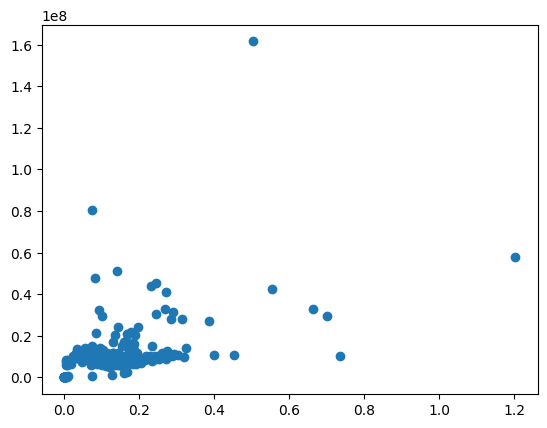

In [30]:
plt.scatter(df['TV'], df['gmv'])
plt.show()

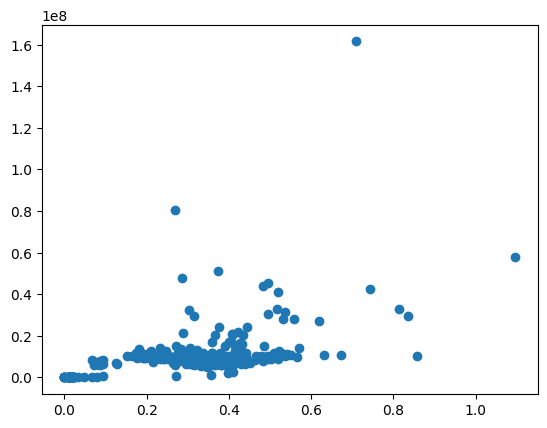

In [31]:
plt.scatter(np.sqrt(df['TV']), df['gmv'])
plt.show()

In [32]:
scaler = StandardScaler()

X_clean = df[feature_cols].copy()
y_clean = df['gmv'].values

X_scaled = scaler.fit_transform(X_clean)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y_clean, test_size=0.2, random_state=42
)

from sklearn.metrics import r2_score, mean_squared_error

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")

R² Score: -3.14
RMSE: 23930189.78


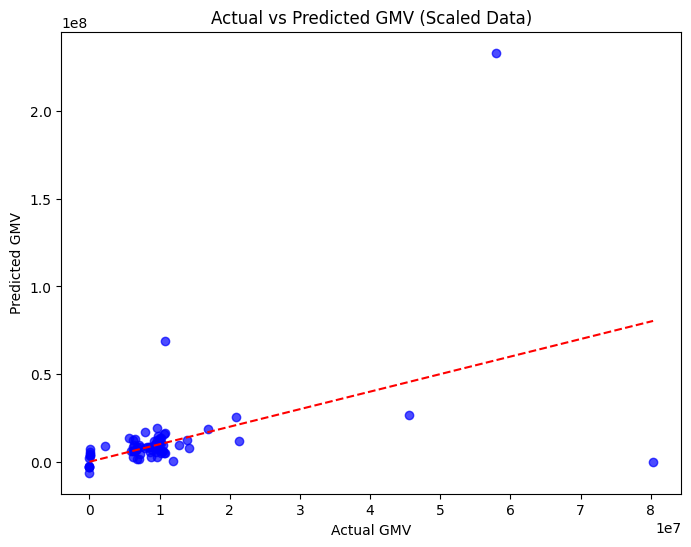

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual GMV')
plt.ylabel('Predicted GMV')
plt.title('Actual vs Predicted GMV (Scaled Data)')
plt.show()

<ipython-input-34-22501180ed46>:33: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100


Gradient Boosting Metrics (Test Set):
  RMSE: 21610858.82
  MAE: 5753185.57
  R²: -2.3747
  MAPE: inf%


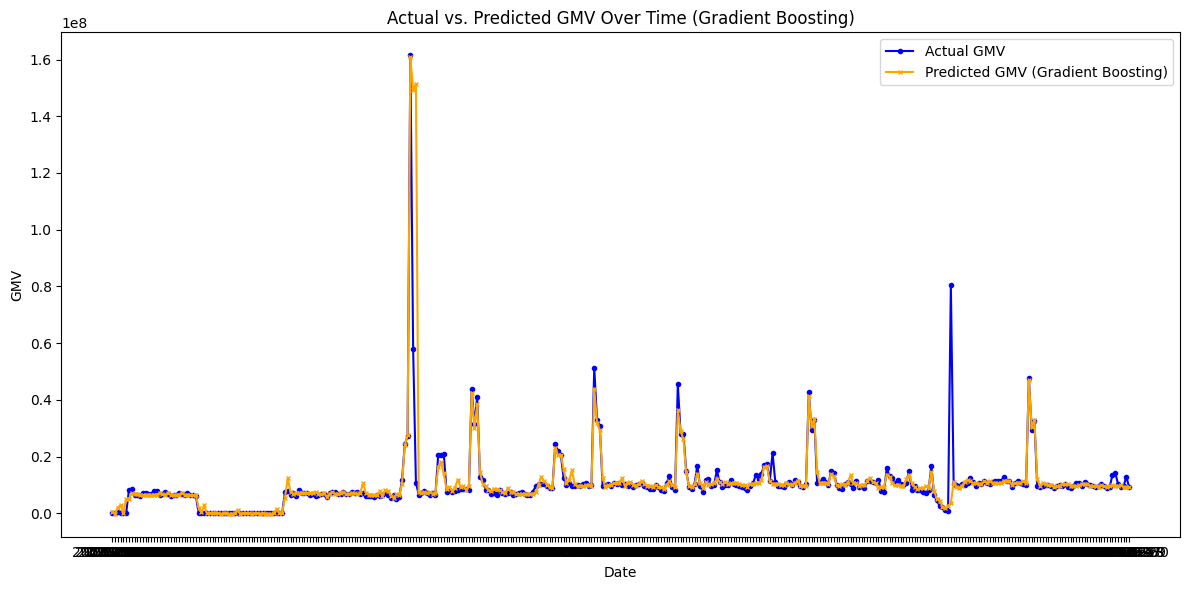

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

feature_cols = [
    'units_lag1', 'gmv_roll7',
    'holiday', 'sale', 'sla', 'pay_day',
    'TV', 'Digital', 'Sponsorship', 'Content_Marketing',
    'Online_marketing', ' Affiliates', 'SEM', 'Radio', 'Other',
    'Total_Disaggregated',
    'adstock_d0.9_l2', 'adstock_d0.9_l7'
]

df = df.sort_values('order_date').reset_index(drop=True)

X = df[feature_cols].copy()
y = df['gmv'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)

y_pred_test = gb_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("Gradient Boosting Metrics (Test Set):")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R²: {r2:.4f}")
print(f"  MAPE: {mape:.2f}%")

X_all_scaled = scaler.transform(X)
predicted_gmv = gb_model.predict(X_all_scaled)

plt.figure(figsize=(12, 6))
plt.plot(df['order_date'], df['gmv'], label='Actual GMV', color='blue', marker='o', markersize=3)
plt.plot(df['order_date'], predicted_gmv, label='Predicted GMV (Gradient Boosting)',
         color='orange', marker='x', markersize=3)
plt.xlabel('Date')
plt.ylabel('GMV')
plt.title('Actual vs. Predicted GMV Over Time (Gradient Boosting)')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
channel_cols = ['TV', 'Digital', 'Sponsorship', 'Content_Marketing',
    'Online_marketing', ' Affiliates', 'SEM', 'Radio', 'Other']

df = dfu


In [36]:
low_spend_threshold = df['Total_Disaggregated'].quantile(0.1)
baseline_df = df[df['Total_Disaggregated'] <= low_spend_threshold]
R_baseline = baseline_df['gmv'].mean()
print(f"Baseline Revenue (R_baseline): {R_baseline:,.2f}")

Baseline Revenue (R_baseline): 938,954.40


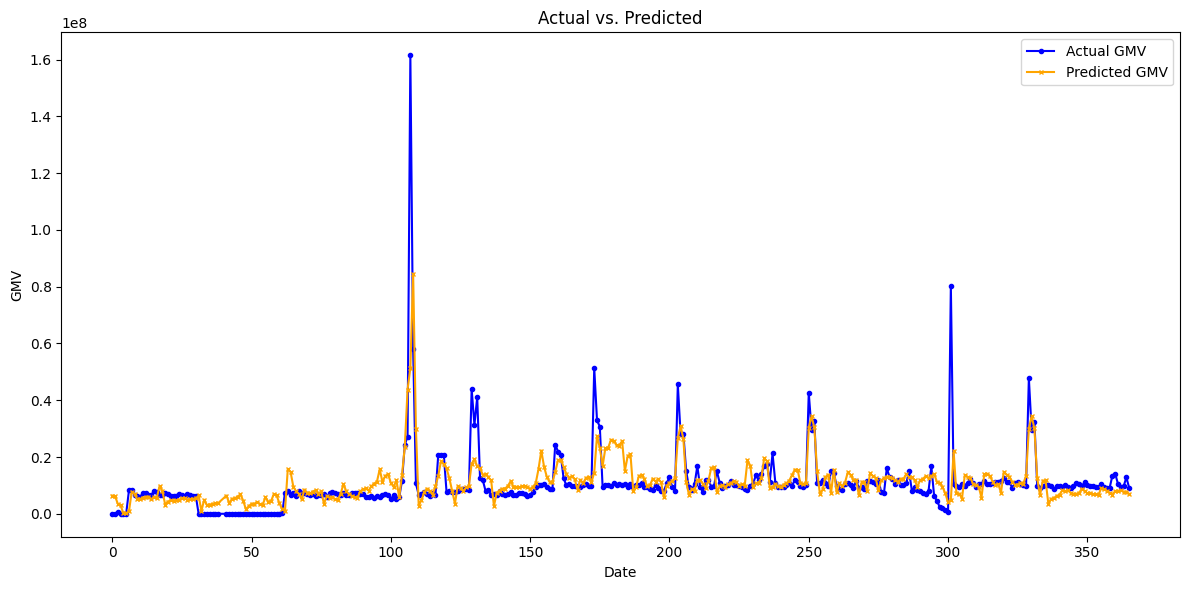

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['gmv'], label='Actual GMV', color='blue', marker='o', markersize=3)
plt.plot(df.index, df['predicted_gmv'], label='Predicted GMV',
         color='orange', marker='x', markersize=3)
plt.xlabel('Date')
plt.ylabel('GMV')
plt.title('Actual vs. Predicted')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
df['inc_rev_pred'] = df['predicted_gmv'] - R_baseline

In [39]:
low_spend_threshold = df['Total_Disaggregated'].quantile(0.05)

# Calculate baseline investment for each channel
baseline_investment = df[df['Total_Disaggregated'] <= low_spend_threshold][channel_cols].mean()

print("Baseline Investment:")
print(baseline_investment)

Baseline Investment:
TV                   1.452943e-04
Digital              1.858243e-02
Sponsorship          1.681432e-02
Content_Marketing    3.268061e-07
Online_marketing     2.152447e-03
 Affiliates          1.173697e-03
SEM                  3.655594e-02
Radio                0.000000e+00
Other                0.000000e+00
dtype: float64


In [40]:
# Calculate incremental investment for each channel
for channel in channel_cols:
    df[f'inc_invest_{channel}'] = df[channel] - baseline_investment[channel]

# Ensure no negative incremental investment (cap at zero)
for channel in channel_cols:
    df[f'inc_invest_{channel}'] = df[f'inc_invest_{channel}'].clip(lower=0)

print(df[[f'inc_invest_{col}' for col in channel_cols]].head())

   inc_invest_TV  inc_invest_Digital  inc_invest_Sponsorship  \
0       0.002240            0.009478                0.065319   
1       0.000000            0.000000                0.000000   
2       0.008896            0.087778                0.294508   
3       0.005983            0.053511                0.194206   
4       0.000899            0.000000                0.019131   

   inc_invest_Content_Marketing  inc_invest_Online_marketing  \
0                      0.000010                     0.012551   
1                      0.000000                     0.000000   
2                      0.000039                     0.053579   
3                      0.000026                     0.035624   
4                      0.000004                     0.004282   

   inc_invest_ Affiliates  inc_invest_SEM  inc_invest_Radio  inc_invest_Other  
0                0.004889        0.019095               0.0               0.0  
1                0.000000        0.000000               0.0           

In [41]:
# Define the spend-response function
def spend_response_func(x, A, B):
    return A * (1 - np.exp(-B * x))

# Dictionary to store fitted parameters
spend_response_params = {}

for channel in channel_cols:
    # Use incremental investment and incremental revenue
    mask = (df[f'inc_invest_{channel}'] > 0) & (df['inc_rev_pred'] > 0)
    x_data = df.loc[mask, f'inc_invest_{channel}'].values
    y_data = df.loc[mask, 'inc_rev_pred'].values

    if len(x_data) < 5:  # Skip channels with insufficient data
        print(f"Skipping {channel} (insufficient data)")
        continue

    try:
        # Fit the curve
        popt, _ = curve_fit(spend_response_func, x_data, y_data, p0=(np.max(y_data), 0.001))
        A, B = popt
        spend_response_params[channel] = {'A': A, 'B': B}
        print(f"{channel}: A={A:.2f}, B={B:.6f}")
    except RuntimeError:
        print(f"Failed to fit {channel}")

TV: A=109334780.21, B=0.696174
Digital: A=10550496.30, B=807.750109
Sponsorship: A=105851100.61, B=0.080173
Content_Marketing: A=47427003.76, B=8.878742
Online_marketing: A=1073002727.06, B=0.016834
Failed to fit  Affiliates
SEM: A=20957589.50, B=4.351489
Radio: A=17757541.24, B=29.420784
Other: A=13368979.16, B=10.148144


In [42]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Linear function
def linear_func(x, A):
    return A * x

# Quadratic function
def quadratic_func(x, A, B):
    return A * x + B * x**2

# Power function
def power_func(x, A, B):
    return A * np.power(x, B)

# Sigmoid (logistic) function
def sigmoid_func(x, A, B, C):
    return A / (1 + np.exp(-B * (x - C)))

# Logarithmic function
def log_func(x, A, B):
    return A * np.log1p(B * x)

# Hyperbolic function
def hyperbolic_func(x, A, B):
    return (A * x) / (B + x)

In [43]:
# Columns representing marketing channels
channel_cols = ['TV', 'Digital', 'Sponsorship', 'Content_Marketing',
                'Online_marketing', ' Affiliates', 'SEM', 'Radio', 'Other']

# Dictionary to store results
channel_fit_results = {}

# Candidate functions
functions = {
    "Linear": linear_func,
    "Quadratic": quadratic_func,
    "Power": power_func,
    "Sigmoid": sigmoid_func,
    "Logarithmic": log_func,
    "Hyperbolic": hyperbolic_func
}

# Loop through each channel
for channel in channel_cols:
    # Filter data for the current channel
    mask = (df[f'inc_invest_{channel}'] > 0) & (df['inc_rev_pred'] > 0)
    channel_data = df.loc[mask, [f'inc_invest_{channel}', 'inc_rev_pred']]

    if len(channel_data) < 5:  # Skip channels with insufficient data
        print(f"Skipping {channel} (insufficient data)")
        continue

    # Extract x and y
    x_data = channel_data[f'inc_invest_{channel}'].values
    y_data = channel_data['inc_rev_pred'].values

    # Dictionary to store results for this channel
    fit_results = {}

    # Fit each function
    for name, func in functions.items():
        try:
            # Initial guesses for parameters
            if name == "Linear":
                popt, _ = curve_fit(func, x_data, y_data, p0=[1])
            elif name == "Quadratic":
                popt, _ = curve_fit(func, x_data, y_data, p0=[1, -0.01])
            elif name == "Power":
                popt, _ = curve_fit(func, x_data, y_data, p0=[1, 0.5])
            elif name == "Sigmoid":
                popt, _ = curve_fit(func, x_data, y_data, p0=[np.max(y_data), 0.01, np.mean(x_data)])
            elif name == "Logarithmic":
                popt, _ = curve_fit(func, x_data, y_data, p0=[1, 0.01])
            elif name == "Hyperbolic":
                popt, _ = curve_fit(func, x_data, y_data, p0=[np.max(y_data), np.mean(x_data)])

            # Predict using fitted parameters
            y_pred = func(x_data, *popt)

            # Calculate R² score
            r2 = r2_score(y_data, y_pred)
            fit_results[name] = {"R2": r2, "Parameters": popt}
        except RuntimeError:
            fit_results[name] = {"R2": None, "Parameters": None}
            print(f"Failed to fit {name} function for {channel}")

    # Store results for the channel
    channel_fit_results[channel] = fit_results

<ipython-input-42-04e758866e7d>:19: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-B * (x - C)))
<ipython-input-43-7dfdb04ffd4d>:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x_data, y_data, p0=[np.max(y_data), 0.01, np.mean(x_data)])
<ipython-input-42-04e758866e7d>:23: RuntimeWarning: invalid value encountered in log1p
  return A * np.log1p(B * x)
<ipython-input-42-04e758866e7d>:19: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-B * (x - C)))
<ipython-input-43-7dfdb04ffd4d>:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x_data, y_data, p0=[np.max(y_data), 0.01, np.mean(x_data)])
<ipython-input-42-04e758866e7d>:23: RuntimeWarning: invalid value encountered in log1p
  return A * np.log1p(B * x)
<ipython-input-43-7dfdb04ffd4d>:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x_data, y

Failed to fit Logarithmic function for  Affiliates
Failed to fit Sigmoid function for Radio
Failed to fit Sigmoid function for Other


In [44]:
# Print results for each channel
for channel, results in channel_fit_results.items():
    print(f"\nResults for Channel: {channel}")
    best_function_name = None
    best_r2 = -np.inf

    for name, result in results.items():
        if result["R2"] is not None:
            print(f"{name}: R² = {result['R2']:.2f}, Parameters = {result['Parameters']}")
            if result["R2"] > best_r2:
                best_r2 = result["R2"]
                best_function_name = name
        else:
            print(f"{name}: Failed to fit")

    print(f"Best Function for {channel}: {best_function_name} (R² = {best_r2:.2f})")


Results for Channel: TV
Linear: R² = 0.44, Parameters = [66308801.91583323]
Quadratic: R² = 0.46, Parameters = [ 72988371.73936838 -15266418.02507236]
Power: R² = 0.52, Parameters = [4.79291391e+07 7.39983886e-01]
Sigmoid: R² = -1.96, Parameters = [5.96016126e+09 1.61307088e+00 1.42174651e+04]
Logarithmic: R² = 0.47, Parameters = [5.65017225e+07 1.46318888e+00]
Hyperbolic: R² = 0.46, Parameters = [1.62297078e+08 2.06182988e+00]
Best Function for TV: Power (R² = 0.52)

Results for Channel: Digital
Linear: R² = -0.55, Parameters = [47101389.78017401]
Quadratic: R² = -0.36, Parameters = [ 76766805.32824707 -18620978.97537703]
Power: R² = 0.23, Parameters = [3.16293872e+07 3.68708896e-01]
Sigmoid: R² = -1.84, Parameters = [5.96019840e+09 7.14822851e-01 1.42171746e+04]
Logarithmic: R² = 0.12, Parameters = [2336537.58694398    2543.18192744]
Hyperbolic: R² = 0.02, Parameters = [1.13046302e+07 1.55106667e-03]
Best Function for Digital: Power (R² = 0.23)

Results for Channel: Sponsorship
Line

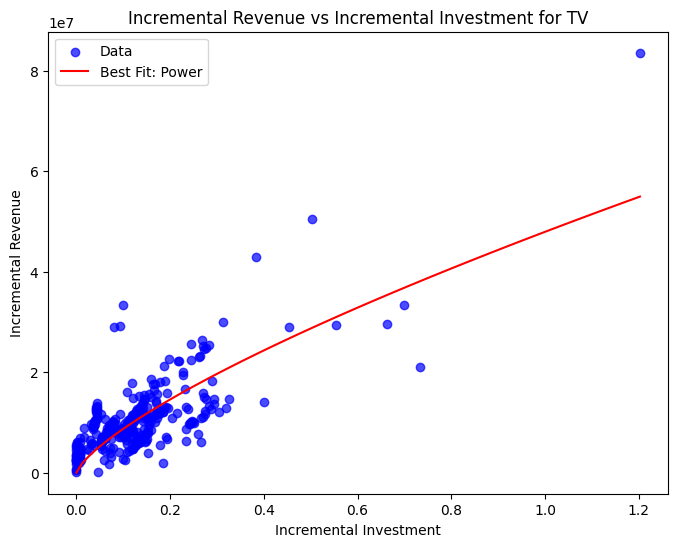

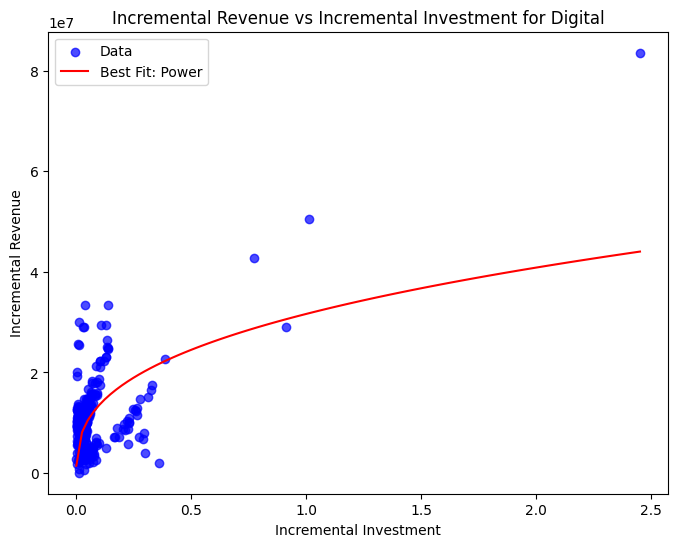

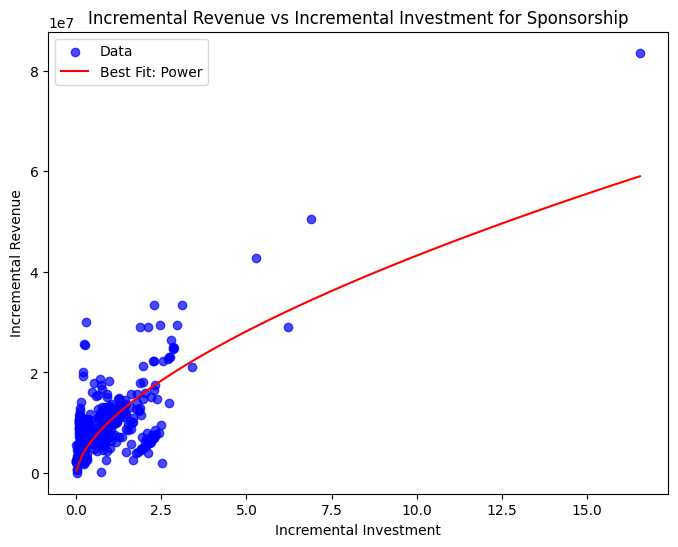

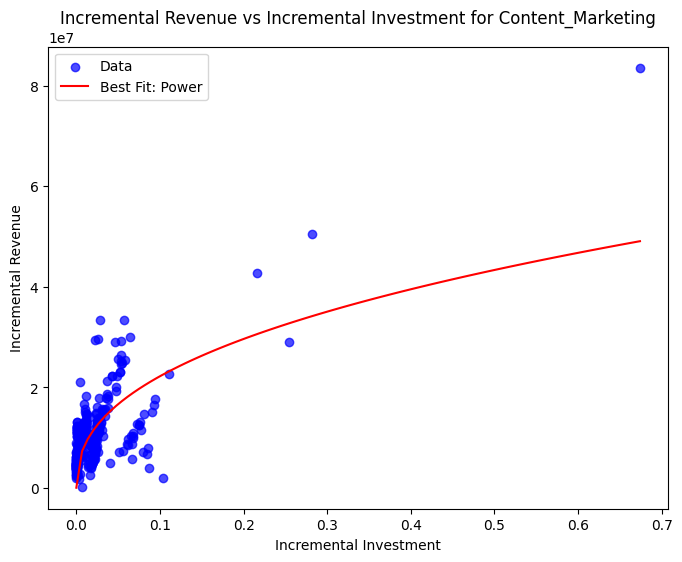

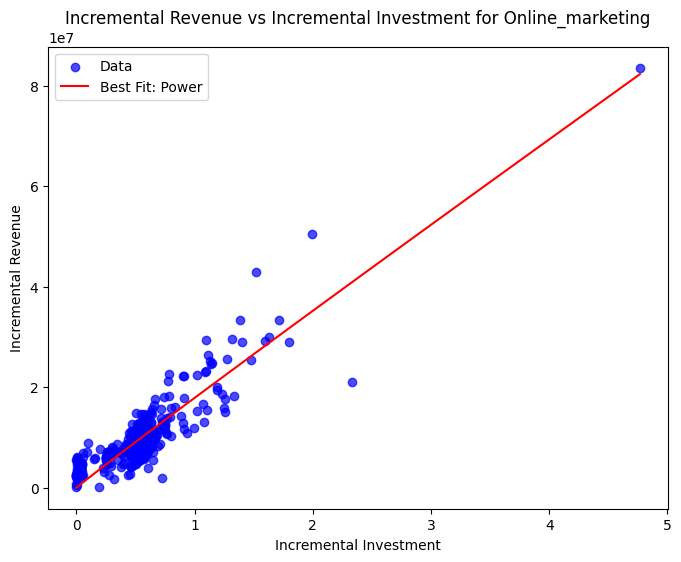

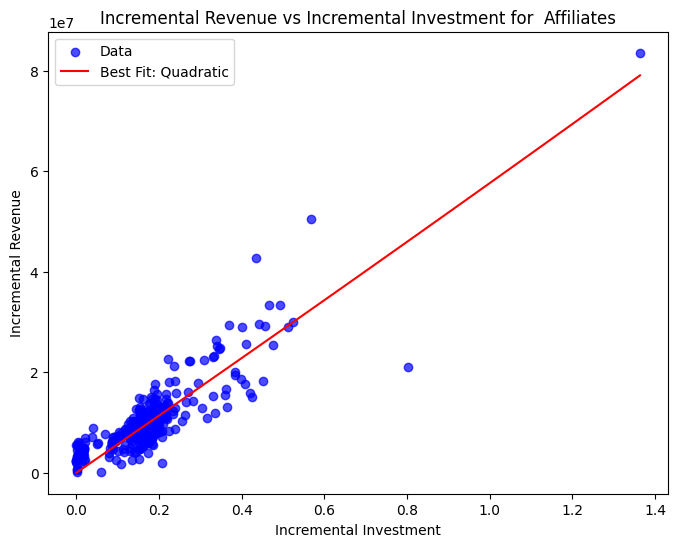

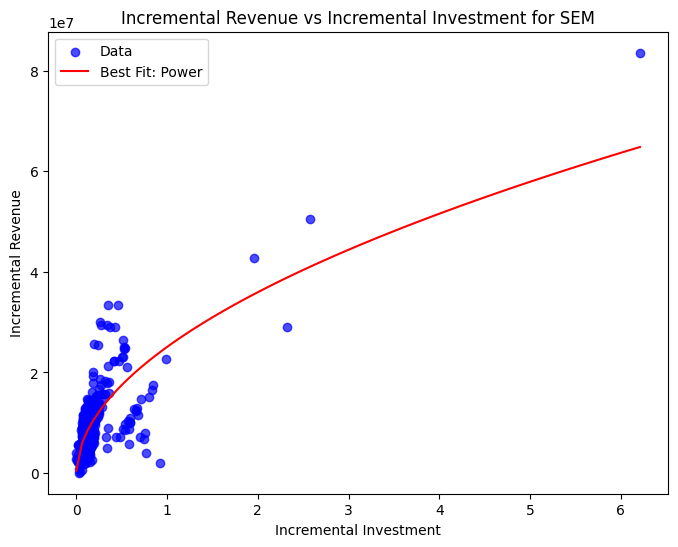

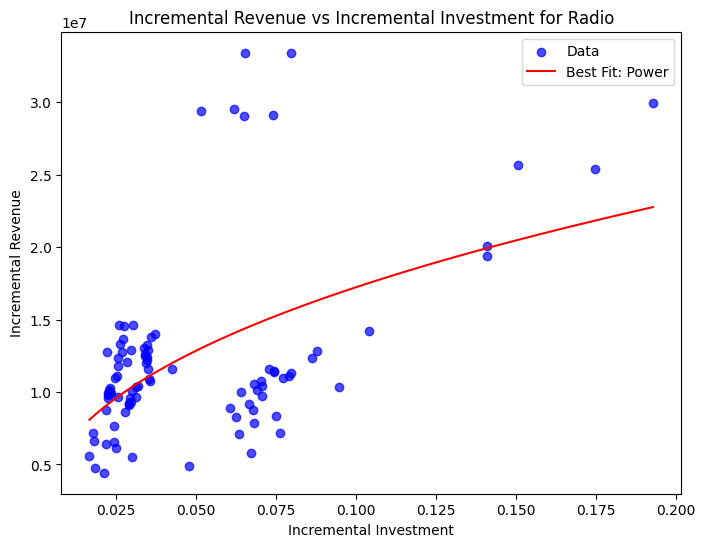

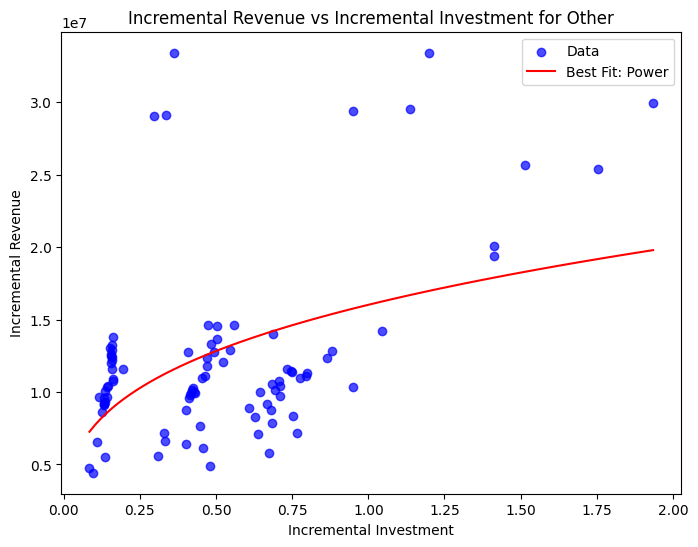

In [45]:
import matplotlib.pyplot as plt

# Visualize the best fit for each channel
for channel, results in channel_fit_results.items():
    # Identify the best function
    best_function_name = max(results, key=lambda k: results[k]["R2"] if results[k]["R2"] is not None else -np.inf)
    best_function = functions[best_function_name]
    best_params = results[best_function_name]["Parameters"]

    # Filter data for the channel
    mask = (df[f'inc_invest_{channel}'] > 0) & (df['inc_rev_pred'] > 0)
    channel_data = df.loc[mask, [f'inc_invest_{channel}', 'inc_rev_pred']]
    x_data = channel_data[f'inc_invest_{channel}'].values
    y_data = channel_data['inc_rev_pred'].values

    # Plot the data and the best fit
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, color='blue', alpha=0.7, label='Data')
    x_range = np.linspace(min(x_data), max(x_data), 100)
    plt.plot(x_range, best_function(x_range, *best_params), color='red', label=f'Best Fit: {best_function_name}')
    plt.title(f'Incremental Revenue vs Incremental Investment for {channel}')
    plt.xlabel('Incremental Investment')
    plt.ylabel('Incremental Revenue')
    plt.legend()
    plt.show()

In [46]:
from scipy.optimize import minimize

# Dictionary to store optimal spend per row
optimal_spend_per_row = []

# Loop through each row in the dataframe
for idx, row in df.iterrows():
    # Get the incremental revenue target for the row
    delta_R = row['inc_rev_pred']
    if delta_R <= 0:  # Skip rows where no additional spend is needed
        optimal_spend_per_row.append({channel: 0 for channel in channel_cols})
        continue

    # Initialize bounds and initial guess
    bounds = [(0, None) for _ in channel_cols]  # Spend cannot be negative
    x0 = [row[f'inc_invest_{channel}'] for channel in channel_cols]  # Initial guess based on actual spend

    # Define the constraint: sum of incremental revenue >= delta_R
    def constraint(x):
        total_inc_rev = 0
        for i, channel in enumerate(channel_cols):
            # Use the best-fitting function for the channel
            best_function_name = max(channel_fit_results[channel],
                                     key=lambda k: channel_fit_results[channel][k]["R2"]
                                                   if channel_fit_results[channel][k]["R2"] is not None else -np.inf)
            best_function = functions[best_function_name]
            best_params = channel_fit_results[channel][best_function_name]["Parameters"]
            total_inc_rev += best_function(x[i], *best_params)
        return total_inc_rev - delta_R  # Must meet or exceed delta_R

    # Solve the optimization problem
    result = minimize(
        fun=lambda x: np.sum(x),  # Minimize total incremental spend
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints={'type': 'ineq', 'fun': constraint}
    )

    # Store results
    optimal_spend_per_row.append(dict(zip(channel_cols, result.x)))

# Convert the list of dictionaries into a DataFrame
optimal_spend_df = pd.DataFrame(optimal_spend_per_row)

# Add optimal spend columns to the original dataframe
for channel in channel_cols:
    df[f'optimal_inc_invest_{channel}'] = optimal_spend_df[channel]

In [47]:
# Add baseline investment to optimal incremental spend
for channel in channel_cols:
    df[f'optimal_total_spend_{channel}'] = df[f'optimal_inc_invest_{channel}'] + baseline_investment[channel]

# Preview the results
print(df[[f'optimal_inc_invest_{col}' for col in channel_cols] +
         [f'optimal_total_spend_{col}' for col in channel_cols]].head())

   optimal_inc_invest_TV  optimal_inc_invest_Digital  \
0           3.462810e-06                    0.000206   
1           4.086207e-08                    0.000166   
2           0.000000e+00                    0.000031   
3           0.000000e+00                    0.000016   
4           0.000000e+00                    0.000000   

   optimal_inc_invest_Sponsorship  optimal_inc_invest_Content_Marketing  \
0                    6.698971e-06                              0.000210   
1                    1.164861e-07                              0.000285   
2                    1.881185e-09                              0.000052   
3                    0.000000e+00                              0.000022   
4                    0.000000e+00                              0.000000   

   optimal_inc_invest_Online_marketing  optimal_inc_invest_ Affiliates  \
0                         2.159943e-16                    0.000000e+00   
1                         8.491156e-17                    4.6578

In [48]:
# Compare actual spend with optimal total spend
print(df[['TV', 'Digital', 'optimal_total_spend_TV', 'optimal_total_spend_Digital']].head())

         TV   Digital  optimal_total_spend_TV  optimal_total_spend_Digital
0  0.002385  0.028060                0.000149                     0.018788
1  0.000000  0.000000                0.000145                     0.018749
2  0.009042  0.106360                0.000145                     0.018613
3  0.006129  0.072093                0.000145                     0.018598
4  0.001044  0.012280                0.000145                     0.018582


In [49]:
# Select relevant columns
summary_cols = ['predicted_gmv', 'inc_rev_pred'] + \
               [f'inc_invest_{col}' for col in channel_cols] + \
               [f'optimal_inc_invest_{col}' for col in channel_cols] + \
               [f'optimal_total_spend_{col}' for col in channel_cols]

# Create the summary dataframe
summary_df = df[summary_cols].copy()

# Rename columns for clarity
rename_dict = {
    'predicted_gmv': 'Predicted GMV',
    'inc_rev_pred': 'Delta R (Inc Rev Target)'
}
for col in channel_cols:
    rename_dict[f'inc_invest_{col}'] = f'{col}: Actual Inc Invest'
    rename_dict[f'optimal_inc_invest_{col}'] = f'{col}: Optimal Inc Invest'
    rename_dict[f'optimal_total_spend_{col}'] = f'{col}: Optimal Total Spend'

summary_df.rename(columns=rename_dict, inplace=True)

# Preview the summary dataframe
display(summary_df.head())

# Melt the dataframe for side-by-side comparison
melted_summary_df = pd.melt(
    summary_df,
    id_vars=['Predicted GMV', 'Delta R (Inc Rev Target)'],
    var_name='Channel_Metric',
    value_name='Value'
)

# Split the 'Channel_Metric' column into separate 'Channel' and 'Metric' columns
melted_summary_df[['Channel', 'Metric']] = melted_summary_df['Channel_Metric'].str.split(': ', expand=True)

# Drop the original 'Channel_Metric' column
melted_summary_df.drop(columns=['Channel_Metric'], inplace=True)

# Pivot the dataframe to show metrics side by side
final_summary_df = melted_summary_df.pivot_table(
    index=['Predicted GMV', 'Delta R (Inc Rev Target)', 'Channel'],
    columns='Metric',
    values='Value',
    aggfunc='first'
).reset_index()

# Reorder columns for clarity
final_summary_df = final_summary_df[[
    'Predicted GMV', 'Delta R (Inc Rev Target)', 'Channel',
    'Actual Inc Invest', 'Optimal Inc Invest', 'Optimal Total Spend'
]]

# Preview the final summary dataframe
final_summary_df.head()

,Predicted GMV,Delta R (Inc Rev Target),TV: Actual Inc Invest,Digital: Actual Inc Invest,Sponsorship: Actual Inc Invest,Content_Marketing: Actual Inc Invest,Online_marketing: Actual Inc Invest,Affiliates: Actual Inc Invest,SEM: Actual Inc Invest,Radio: Actual Inc Invest,...,Other: Optimal Inc Invest,TV: Optimal Total Spend,Digital: Optimal Total Spend,Sponsorship: Optimal Total Spend,Content_Marketing: Optimal Total Spend,Online_marketing: Optimal Total Spend,Affiliates: Optimal Total Spend,SEM: Optimal Total Spend,Radio: Optimal Total Spend,Other: Optimal Total Spend
0,6.433169e+06,5.494215e+06,0.002240,0.009478,0.065319,0.000010,0.012551,0.004889,0.019095,0.0,...,0.000227,0.000149,0.018788,0.016821,2.100720e-04,0.002152,0.001174,0.036573,0.000194,0.000227
1,6.210124e+06,5.271170e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000092,0.000145,0.018749,0.016814,2.849808e-04,0.002152,0.001174,0.036569,0.000174,0.000092
2,3.539125e+06,2.600171e+06,0.008896,0.087778,0.294508,0.000039,0.053579,0.021805,0.174387,0.0,...,0.000017,0.000145,0.018613,0.016814,5.202697e-05,0.002152,0.001174,0.036557,0.000020,0.000017
3,2.950796e+06,2.011841e+06,0.005983,0.053511,0.194206,0.000026,0.035624,0.014402,0.106425,0.0,...,0.000010,0.000145,0.018598,0.016814,2.255046e-05,0.002152,0.001174,0.036557,0.000013,0.000010
4,1.840355e+05,-7.549189e+05,0.000899,0.000000,0.019131,0.000004,0.004282,0.001479,0.000000,0.0,...,0.000000,0.000145,0.018582,0.016814,3.268061e-07,0.002152,0.001174,0.036556,0.000000,0.000000


Metric,Predicted GMV,Delta R (Inc Rev Target),Channel,Actual Inc Invest,Optimal Inc Invest,Optimal Total Spend
0,184035.470824,-754918.929169,Affiliates,0.001479,0.0,1.173697e-03
1,184035.470824,-754918.929169,Content_Marketing,0.000004,0.0,3.268061e-07
2,184035.470824,-754918.929169,Digital,0.000000,0.0,1.858243e-02
3,184035.470824,-754918.929169,Online_marketing,0.004282,0.0,2.152447e-03
4,184035.470824,-754918.929169,Other,0.000000,0.0,0.000000e+00


In [50]:
final_summary_df

Metric,Predicted GMV,Delta R (Inc Rev Target),Channel,Actual Inc Invest,Optimal Inc Invest,Optimal Total Spend
0,1.840355e+05,-7.549189e+05,Affiliates,0.001479,0.000000e+00,1.173697e-03
1,1.840355e+05,-7.549189e+05,Content_Marketing,0.000004,0.000000e+00,3.268061e-07
2,1.840355e+05,-7.549189e+05,Digital,0.000000,0.000000e+00,1.858243e-02
3,1.840355e+05,-7.549189e+05,Online_marketing,0.004282,0.000000e+00,2.152447e-03
4,1.840355e+05,-7.549189e+05,Other,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
3271,8.449095e+07,8.355200e+07,Other,0.000000,8.999094e-06,8.999094e-06
3272,8.449095e+07,8.355200e+07,Radio,0.000000,1.117886e-05,1.117886e-05
3273,8.449095e+07,8.355200e+07,SEM,6.211539,4.916400e-07,3.655643e-02
3274,8.449095e+07,8.355200e+07,Sponsorship,16.553544,5.795474e-21,1.681432e-02


In [51]:
df_optimized = df.copy()

# Replace actual incremental investment with optimal incremental investment
for channel in channel_cols:
    df_optimized[f'inc_invest_{channel}'] = df[f'optimal_inc_invest_{channel}']

In [52]:
# Identify numeric columns (excluding binary flags)
numeric_cols = [col for col in feature_cols if df[col].dtype in ['float64', 'int64'] and col not in ['holiday', 'sale', 'pay_day']]

# Binary columns remain unchanged
binary_cols = ['holiday', 'sale', 'pay_day']

In [53]:
# Scale the features using the same scaler
X_optimized = df_optimized[feature_cols].copy()
X_optimized_scaled = scaler.transform(X_optimized)
# Predict GMV using the trained model
y_pred_optimized_transformed = lr_model.predict(X_optimized_scaled)

y_pred_optimized_original = y_pred_optimized_transformed

# Add the new predictions to the dataframe
df_optimized['predicted_gmv_new'] = y_pred_optimized_original


In [54]:
# Add the comparison to the dataframe
df_optimized['gmv_improvement'] = df_optimized['predicted_gmv_new'] - df_optimized['predicted_gmv']

# Check if all new predictions are >= old predictions
is_valid = (df_optimized['gmv_improvement'] >= 0).all()

print(f"All new predictions are >= old predictions: {is_valid}")

# Preview the results
print(df_optimized[['gmv', 'predicted_gmv', 'predicted_gmv_new', 'gmv_improvement']].head())

All new predictions are >= old predictions: False
        gmv  predicted_gmv  predicted_gmv_new  gmv_improvement
0   20747.0   6.433169e+06      -5.644952e+05    -6.997664e+06
1       0.0   6.210124e+06       6.985526e+06     7.754014e+05
2  568303.0   3.539125e+06       2.547112e+07     2.193200e+07
3   81821.0   2.950796e+06       8.034953e+06     5.084157e+06
4    1899.0   1.840355e+05      -1.966328e+07    -1.984731e+07


In [55]:
# Add a binary column to indicate improvement
df_optimized['is_improved'] = (df_optimized['gmv_improvement'] >= 0).astype(int)

In [56]:
# Add percentage increase column for predicted GMV
df_optimized['percent_increase_pred'] = (
    (df_optimized['predicted_gmv_new'] - df_optimized['predicted_gmv']) / df_optimized['predicted_gmv']
) * 100

In [57]:
# Add percentage increase column from actual GMV
df_optimized['percent_actual'] = (
    (df_optimized['predicted_gmv_new'] - df_optimized['gmv']) / df_optimized['gmv']
) * 100

In [58]:
# Preview the relevant columns
result_summary = df_optimized[[
    'gmv', 'predicted_gmv', 'predicted_gmv_new',
    'percent_increase_pred', 'percent_actual', 'is_improved'
]]
print(result_summary.head())

        gmv  predicted_gmv  predicted_gmv_new  percent_increase_pred  \
0   20747.0   6.433169e+06      -5.644952e+05            -108.774760   
1       0.0   6.210124e+06       6.985526e+06              12.486085   
2  568303.0   3.539125e+06       2.547112e+07             619.701037   
3   81821.0   2.950796e+06       8.034953e+06             172.297832   
4    1899.0   1.840355e+05      -1.966328e+07          -10784.503724   

   percent_actual  is_improved  
0   -2.820852e+03            0  
1             inf            1  
2    4.381962e+03            1  
3    9.720159e+03            1  
4   -1.035554e+06            0  


In [59]:
# Count the number of rows with no improvement
num_no_improvement = (df_optimized['is_improved'] == 0).sum()

print(f"Number of rows with no improvement: {num_no_improvement}")

Number of rows with no improvement: 239


In [60]:
# Calculate the average percentage increase in predicted GMV
average_percent_increase_pred = df_optimized['percent_increase_pred'].mean()

print(f"Average Percentage Increase in Predicted GMV: {average_percent_increase_pred:.2f}%")

Average Percentage Increase in Predicted GMV: -65.81%


In [61]:
# Calculate the average percentage increase in predicted GMV
average_percent_increase_pred = df_optimized['percent_actual'].mean()

print(f"Average Percentage Increase in Predicted GMV: {average_percent_increase_pred:.2f}%")

Average Percentage Increase in Predicted GMV: inf%


In [62]:
# Calculate incremental revenue for each channel using optimal spend
for channel in channel_cols:
    # Get the best-fitting function for the channel
    best_function_name = max(channel_fit_results[channel],
                             key=lambda k: channel_fit_results[channel][k]["R2"]
                                           if channel_fit_results[channel][k]["R2"] is not None else -np.inf)
    best_function = functions[best_function_name]
    best_params = channel_fit_results[channel][best_function_name]["Parameters"]

    # Calculate f(x) for the optimal incremental spend
    df[f'predicted_inc_rev_{channel}'] = df[f'optimal_inc_invest_{channel}'].apply(
        lambda x: best_function(x, *best_params) if x > 0 else 0
    )

In [63]:
# Sum incremental revenues across channels
df['total_predicted_inc_rev'] = df[[f'predicted_inc_rev_{col}' for col in channel_cols]].sum(axis=1)

In [64]:
# Add a column to check if the revenue constraint is met
df['revenue_constraint_met'] = df['total_predicted_inc_rev'] >= df['inc_rev_pred']

# Preview the results
print(df[['inc_rev_pred', 'total_predicted_inc_rev', 'revenue_constraint_met']].head())

   inc_rev_pred  total_predicted_inc_rev  revenue_constraint_met
0  5.494215e+06             5.493673e+06                   False
1  5.271170e+06             5.271170e+06                    True
2  2.600171e+06             2.600171e+06                    True
3  2.011841e+06             2.011841e+06                    True
4 -7.549189e+05             0.000000e+00                    True


In [ ]:
boxcox_columns = [col for col in feature_cols if col in df.columns]

for col in boxcox_columns:
    # Ensure no non-positive values (shift if necessary)
    if (df_optimized[col] <= 0).any():
        df_optimized[col] = df_optimized[col] + 1  # Shift values to make them positive

    # Apply Box-Cox using the lambda_ values from training
    df_optimized[col], _ = boxcox(df_optimized[col])  # Use the same lambda_ as during training

In [77]:
# Extract features from the optimized dataframe
X_optimized = df_optimized[feature_cols].copy()

# Scale the features using the same scaler
X_optimized_scaled = scaler.transform(X_optimized)

# Predict GMV using the trained model
y_pred_optimized_transformed = lr_model.predict(X_optimized_scaled)

# Inverse transform predictions to the original scale
from scipy.special import inv_boxcox
y_pred_optimized_original = y_pred_optimized_transformed

# Add the new predictions to the dataframe
df_optimized['predicted_gmv_new'] = y_pred_optimized_original

In [78]:
# Add actual total spend columns to the summary dataframe
for col in channel_cols:
    summary_df[f'{col}: Actual Total Spend'] = df[col]

# Rename columns for clarity
rename_dict = {
    'predicted_gmv': 'Predicted GMV',
    'inc_rev_pred': 'Delta R (Inc Rev Target)'
}
for col in channel_cols:
    rename_dict[f'inc_invest_{col}'] = f'{col}: Actual Inc Invest'
    rename_dict[f'optimal_inc_invest_{col}'] = f'{col}: Optimal Inc Invest'
    rename_dict[f'optimal_total_spend_{col}'] = f'{col}: Optimal Total Spend'
    rename_dict[col] = f'{col}: Actual Total Spend'

summary_df.rename(columns=rename_dict, inplace=True)

In [68]:
# Add actual GMV to the summary dataframe
summary_df['Actual GMV'] = df['gmv']

In [69]:
import pandas as pd

# Melt the dataframe for side-by-side comparison
melted_summary_df = pd.melt(
    summary_df,
    id_vars=['Predicted GMV', 'Actual GMV', 'Delta R (Inc Rev Target)'],
    var_name='Channel_Metric',
    value_name='Value'
)

# Split the 'Channel_Metric' column into separate 'Channel' and 'Metric' columns
melted_summary_df[['Channel', 'Metric']] = melted_summary_df['Channel_Metric'].str.split(': ', expand=True)

# Drop the original 'Channel_Metric' column
melted_summary_df.drop(columns=['Channel_Metric'], inplace=True)

# Pivot the dataframe to show metrics side by side
final_summary_df = melted_summary_df.pivot_table(
    index=['Predicted GMV', 'Actual GMV', 'Delta R (Inc Rev Target)', 'Channel'],
    columns='Metric',
    values='Value',
    aggfunc='first'
).reset_index()

# Reorder columns for clarity
final_summary_df = final_summary_df[[
    'Predicted GMV', 'Actual GMV', 'Delta R (Inc Rev Target)', 'Channel',
    'Actual Total Spend', 'Actual Inc Invest', 'Optimal Inc Invest', 'Optimal Total Spend'
]]

# Preview the final summary dataframe
print(final_summary_df.head())

Metric  Predicted GMV  Actual GMV  Delta R (Inc Rev Target)  \
0       184035.470824      1899.0            -754918.929169   
1       184035.470824      1899.0            -754918.929169   
2       184035.470824      1899.0            -754918.929169   
3       184035.470824      1899.0            -754918.929169   
4       184035.470824      1899.0            -754918.929169   

Metric            Channel  Actual Total Spend  Actual Inc Invest  \
0              Affiliates            0.002653           0.001479   
1       Content_Marketing            0.000005           0.000004   
2                 Digital            0.012280           0.000000   
3        Online_marketing            0.006435           0.004282   
4                   Other            0.000000           0.000000   

Metric  Optimal Inc Invest  Optimal Total Spend  
0                      0.0         1.173697e-03  
1                      0.0         3.268061e-07  
2                      0.0         1.858243e-02  
3           

In [72]:

channel_cols = ['TV', 'Digital', 'Sponsorship', 'Content_Marketing',
                'Online_marketing', ' Affiliates', 'SEM', 'Radio', 'Other']

channel_params = {}

def spend_response_func(x, A, B):
    return A * (1 - np.exp(-B * x))

for channel in channel_cols:
    mask = (df[channel] > 0) & (df['inc_rev_pred'] > 0)
    x = df.loc[mask, channel].values
    y = df.loc[mask, 'inc_rev_pred'].values

    if len(x) < 5:
        print(f"Skipping {channel} (insufficient data)")
        continue

    try:
        popt, _ = curve_fit(spend_response_func, x, y,
                           p0=(np.max(y), 0.001), maxfev=5000)
        A, B = popt
        channel_params[channel] = {'A': A, 'B': B}
        print(f"{channel}: A={A:.2f}, B={B:.6f}")
    except RuntimeError:
        print(f"Failed to fit {channel}")

TV: A=109566856.94, B=0.694092
Digital: A=14722982.98, B=23.335569
Sponsorship: A=106480643.03, B=0.079114
Content_Marketing: A=47426188.69, B=8.878943
Online_marketing: A=1174254507.33, B=0.015329
 Affiliates: A=106028632739.69, B=0.000536
SEM: A=44938872.99, B=1.038493
Radio: A=17757541.24, B=29.420784
Other: A=13368979.16, B=10.148144
